# 1. Install and Import Dependencies

In [41]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [42]:
!pip install stable-baselines3[extra] protobuf==3.20.*


  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Using cached rich-13.4.2-py3-none-any.whl (239 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached AutoROM.accept_rom_license-0.6.1-py3-none-any.whl
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [43]:
!pip install mss pydirectinput pytesseract

In [44]:
#chrome://dino/

In [52]:
!pip install pytesseract
!pip install tesseract
!pip install tesseract-ocr

     --------------------------------------- 45.6/45.6 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562552 sha256=2f37ed08fdf72db9c17d750821f438369fd78cab66a003e46bf11514ae5f18d0
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\6c\c5\81\8310cc52076953e53412ed1875a5e224c92940235bdcee21a2
Successfully built tesseract


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tesseract-ocr
Failed to build tesseract-ocr
  Running setup.py install for tesseract-ocr: started
  Running setup.py install for tesseract-ocr: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [10 lines of output]
  C:\Users\User\anaconda3\lib\site-packages\setuptools\dist.py:771: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
    warnings.warn(
  running bdist_wheel
  running build
  running build_py
  file tesseract_ocr.py (for module tesseract_ocr) not found
  file tesseract_ocr.py (for module tesseract_ocr) not found
  running build_ext
  building 'tesseract_ocr' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tesseract-ocr
  error: subprocess-exited-with-error
  
  Running setup.py install

In [25]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [26]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

# 2.2 Test Environment

In [27]:
env = WebGame()

In [28]:
obs=env.get_observation()

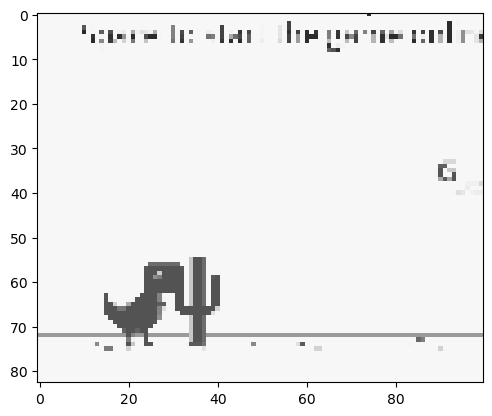

In [30]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [40]:
pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR/tesseract.exe'

done, done_cap = env.get_done()

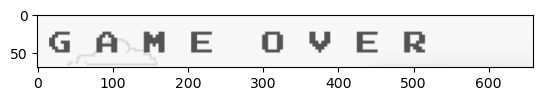

In [41]:
plt.imshow(done_cap)

In [43]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [44]:
done

True

In [45]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 12
Total Reward for episode 1 is 13
Total Reward for episode 2 is 11
Total Reward for episode 3 is 12
Total Reward for episode 4 is 11


KeyboardInterrupt: 

# 3. Train the Model

## 3.1 Create Callback

In [47]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [48]:
env_checker.check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

In [57]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [58]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [59]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [60]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [61]:
env = WebGame()

In [62]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

In [ ]:
model.load('train_first/best_mode l_50000')

# 4. Test out Model

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)